In [16]:
import os
os.getcwd()

'/mnt/c/Users/hitga/Capstone/HouseTS Dataset/Capstone-Housing-Price-Prediction'

In [17]:
#Installing libraries
!pip install pandas
!pip install scikit-learn
!pip install scipy
!pip install matplotlib seaborn
!pip install seaborn
!pip install xgboost
!pip install shap




In [18]:
#Import libraries and load dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

#Load Dataset
df = pd.read_csv('/mnt/c/Users/hitga/Capstone/HouseTS Dataset/Capstone-Housing-Price-Prediction/HouseTS.csv')
print ("Initial data shape:", df.shape)
print(df.head())

Initial data shape: (884092, 39)
         date  median_sale_price  median_list_price  median_ppsf  \
0  2012-03-31            46550.0           217450.0    31.813674   
1  2012-04-30            61870.0           245000.0    40.723982   
2  2012-05-31           125500.0           217450.0    63.913043   
3  2012-06-30           153000.0           189900.0    81.598080   
4  2012-07-31           165500.0           154000.0    81.598080   

   median_list_ppsf  homes_sold  pending_sales  new_listings  inventory  \
0        110.183666        14.0           23.0          44.0       64.0   
1        130.528256        22.0           29.0          56.0       69.0   
2        119.919216        24.0           40.0          63.0       60.0   
3        105.617353        34.0           46.0          50.0       57.0   
4         83.921175        39.0           49.0          42.0       50.0   

   median_dom  ...  Total Housing Units  Median Rent  Median Home Value  \
0        59.5  ...              

In [19]:
#Map city code to city names
# Create a dictionary mapping city codes to full names
city_map = {
    'ATL': 'Atlanta',
    'ATX': 'Austin',
    'BOS': 'Boston',
    'BWI': 'Baltimore-Washington',
    'CHI': 'Chicago',
    'CIN': 'Cincinnati',
    'CLT': 'Charlotte',
    'DAL': 'Dallas',
    'DC': 'Washington DC',
    'DEN': 'Denver',
    'DET': 'Detroit',
    'HOU': 'Houston',
    'LA': 'Los Angeles',
    'LV': 'Las Vegas',
    'MIA': 'Miami',
    'MSP': 'Minneapolis-St. Paul',
    'NY': 'New York',
    'ORL': 'Orlando',
    'PDX': 'Portland',
    'PGH': 'Pittsburgh',
    'PHL': 'Philadelphia',
    'PHX': 'Phoenix',
    'RIV': 'Riverside',
    'SA': 'San Antonio',
    'SAC': 'Sacramento',
    'SD': 'San Diego',
    'SEA': 'Seattle',
    'SF': 'San Francisco',
    'STL': 'St. Louis',
    'TPA': 'Tampa'
}

# Map city codes to full names in a new column
df['city_full_name'] = df['city'].map(city_map)

# Verify the mapping
df[['city', 'city_full_name']].head()

,city,city_full_name
0,ATL,Atlanta
1,ATL,Atlanta
2,ATL,Atlanta
3,ATL,Atlanta
4,ATL,Atlanta


In [20]:
#Date/Time Feature Engineering

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df = df.drop(columns=['date'])

In [21]:
#Handle any infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
#Check for NaNs
print("NaNs before filling:\n", df.isna().sum())

NaNs before filling:
 median_sale_price               0
median_list_price               0
median_ppsf                     0
median_list_ppsf                0
homes_sold                      0
pending_sales                   0
new_listings                    0
inventory                       0
median_dom                      0
avg_sale_to_list                0
sold_above_list                 0
off_market_in_two_weeks         0
city                            0
zipcode                         0
year                            0
bank                            0
bus                             0
hospital                        0
mall                            0
park                            0
restaurant                      0
school                          0
station                         0
supermarket                     0
Total Population                0
Median Age                      0
Per Capita Income               0
Total Families Below Poverty    0
Total Housing Units       

In [23]:
#Check for duplicate rows and drop 
duplicate_count = df.duplicated().sum()
if duplicate_count > 0:
    df = df.drop_duplicates()
    print("Duplicate rows dropped. New shape:", df.shape)
else:
    print("No duplicate rows found.")


No duplicate rows found.


In [24]:
#View data types of all columns
print("Column data types:\n", df.dtypes)

Column data types:
 median_sale_price               float64
median_list_price               float64
median_ppsf                     float64
median_list_ppsf                float64
homes_sold                      float64
pending_sales                   float64
new_listings                    float64
inventory                       float64
median_dom                      float64
avg_sale_to_list                float64
sold_above_list                 float64
off_market_in_two_weeks         float64
city                             object
zipcode                           int64
year                              int32
bank                            float64
bus                             float64
hospital                        float64
mall                            float64
park                            float64
restaurant                      float64
school                          float64
station                         float64
supermarket                     float64
Total Population    

In [25]:
#Convert Zip code to string so treated as categorical
df['zipcode'] = df['zipcode'].astype(str)
print("\nUpdated 'zipcode' data type:", df['zipcode'].dtype)


Updated 'zipcode' data type: object


In [26]:
#Label Encode
from sklearn.preprocessing import LabelEncoder

cat_cols = [c for c in df.select_dtypes(include=['category']).columns if c != 'city_full_name']

for col in cat_cols:
    if not pd.api.types.is_categorical_dtype(df[col]):
        df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes



In [27]:
# Scale numerical values
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first = True)
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns
scaler=StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


In [28]:
#Check for any missing or infinite values after processing
import numpy as np

print("Missing values after processing:", df_encoded.isna().sum().sum())

# Select numeric columns only
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns

# Check for infinite values only in numeric columns
inf_count = np.isinf(df_encoded[numeric_cols]).sum().sum()
print("Infinite values after processing:", inf_count)


Missing values after processing: 0
Infinite values after processing: 0


In [29]:
#Remove any outliers
from scipy import stats

z_scores = stats.zscore(df.select_dtypes(include=['float64', 'int64']))
df = df[(abs(z_scores) < 3).all(axis=1)]

In [30]:
#Preview Cleaned, encoded, and scaled data
print(df_encoded.head())

   median_sale_price  median_list_price  median_ppsf  median_list_ppsf  \
0          -0.910902          -0.108222    -0.274506         -0.417021   
1          -0.870749          -0.093716    -0.261717         -0.346896   
2          -0.703981          -0.108222    -0.228434         -0.383464   
3          -0.631907          -0.122728    -0.203051         -0.432760   
4          -0.599145          -0.141631    -0.203051         -0.507544   

   homes_sold  pending_sales  new_listings  inventory  median_dom  \
0   -0.817786      -0.685259     -0.527644  -0.149377   -0.021769   
1   -0.713481      -0.614941     -0.398188  -0.093223    0.343104   
2   -0.687405      -0.486026     -0.322672  -0.194300    1.012037   
3   -0.557024      -0.415709     -0.462916  -0.227992    0.787032   
4   -0.491833      -0.380551     -0.549220  -0.306607    0.227560   

   avg_sale_to_list  ...  Unemployed Population  Total School Age Population  \
0         -0.544303  ...              -0.387293             

In [31]:
print(df['city_full_name'].unique())

['Atlanta' 'Austin' 'Boston' 'Baltimore-Washington' 'Chicago' 'Cincinnati'
 'Charlotte' 'Dallas' 'Washington DC' 'Denver' 'Detroit' 'Houston'
 'Los Angeles' 'Las Vegas' 'Miami' 'Minneapolis-St. Paul' 'New York'
 'Orlando' 'Portland' 'Pittsburgh' 'Philadelphia' 'Phoenix' 'Riverside'
 'San Antonio' 'Sacramento' 'San Diego' 'Seattle' 'San Francisco'
 'St. Louis' 'Tampa']


In [17]:
#Save to CSV for later use
df_encoded.to_csv('cleaned_scaled_data.csv', index=False)
print("Cleaned and scaled data saved to 'cleaned_scaled_data.csv'")

Cleaned and scaled data saved to 'cleaned_scaled_data.csv'


In [32]:
print(df.head(10))
print(df.columns)


   median_sale_price  median_list_price  median_ppsf  median_list_ppsf  \
0            46550.0           217450.0    31.813674        110.183666   
1            61870.0           245000.0    40.723982        130.528256   
2           125500.0           217450.0    63.913043        119.919216   
3           153000.0           189900.0    81.598080        105.617353   
4           165500.0           154000.0    81.598080         83.921175   
5           140250.0           145000.0    78.918228         84.985207   
6           140000.0           103950.0    78.918228         81.447964   
7           143375.0           155000.0    81.286982        105.186323   
8           137000.0           219000.0    81.286982        120.959378   
9           214500.0           219000.0   100.255195        120.959378   

   homes_sold  pending_sales  new_listings  inventory  median_dom  \
0        14.0           23.0          44.0       64.0        59.5   
1        22.0           29.0          56.0     

In [33]:
# Convert city numeric codes to categorical dtype
df['city'] = df['city'].astype('category')

# Check the categories
print(df['city'].cat.categories)

# Label encode the city
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['city_encoded'] = le.fit_transform(df['city'])

# Now 'city_encoded' is a numeric feature 
print(df[['city', 'city_encoded']].head())


Index(['ATL', 'ATX', 'BOS', 'BWI', 'CHI', 'CIN', 'CLT', 'DAL', 'DC', 'DEN',
       'DET', 'HOU', 'LA', 'LV', 'MIA', 'MSP', 'NY', 'ORL', 'PDX', 'PGH',
       'PHL', 'PHX', 'RIV', 'SA', 'SAC', 'SD', 'SEA', 'SF', 'STL', 'TPA'],
      dtype='object')
  city  city_encoded
0  ATL             0
1  ATL             0
2  ATL             0
3  ATL             0
4  ATL             0


In [64]:
#Linear Regression and Random Forest Comparison side by side
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib  # for pipeline caching

# Reduce data size to 30% for quicker testing
df_sample = df.sample(frac=0.3, random_state=42)
X = df_sample.drop('price', axis=1)
y = df_sample['price']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Identify columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# Fill missing & convert types (do on train and test)
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')
for col in numeric_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

memory = joblib.Memory(location='./cache_dir', verbose=0)

# Define pipelines for both models
pipelines = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1))
    ], memory=memory),

    "Linear Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ], memory=memory)
}

for model_name, pipeline in pipelines.items():
    print(f"== {model_name} ==")
    # Cross-validation with 3 folds and parallel jobs
    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rmse_cv = np.sqrt(-cv_scores)
    print(f"CV RMSE scores: {rmse_cv}")
    print(f"Mean CV RMSE: {rmse_cv.mean():.2f}")

    # Fit final model on full training data
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Calculate test metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    print(f"Test RMSE: {rmse_test:.2f}")
    print(f"Test MAE: {mae_test:.2f}")
    print(f"Test R^2: {r2_test:.3f}\n")




== Random Forest ==
CV RMSE scores: [33495.49119846 32857.2312723  33160.02756836]
Mean CV RMSE: 33170.92
Test RMSE: 31217.43
Test MAE: 17532.06
Test R^2: 0.980

== Linear Regression ==
CV RMSE scores: [50431.52562155 49339.95267784 50113.03231424]
Mean CV RMSE: 49961.50
Test RMSE: 50900.10
Test MAE: 29927.00
Test R^2: 0.946



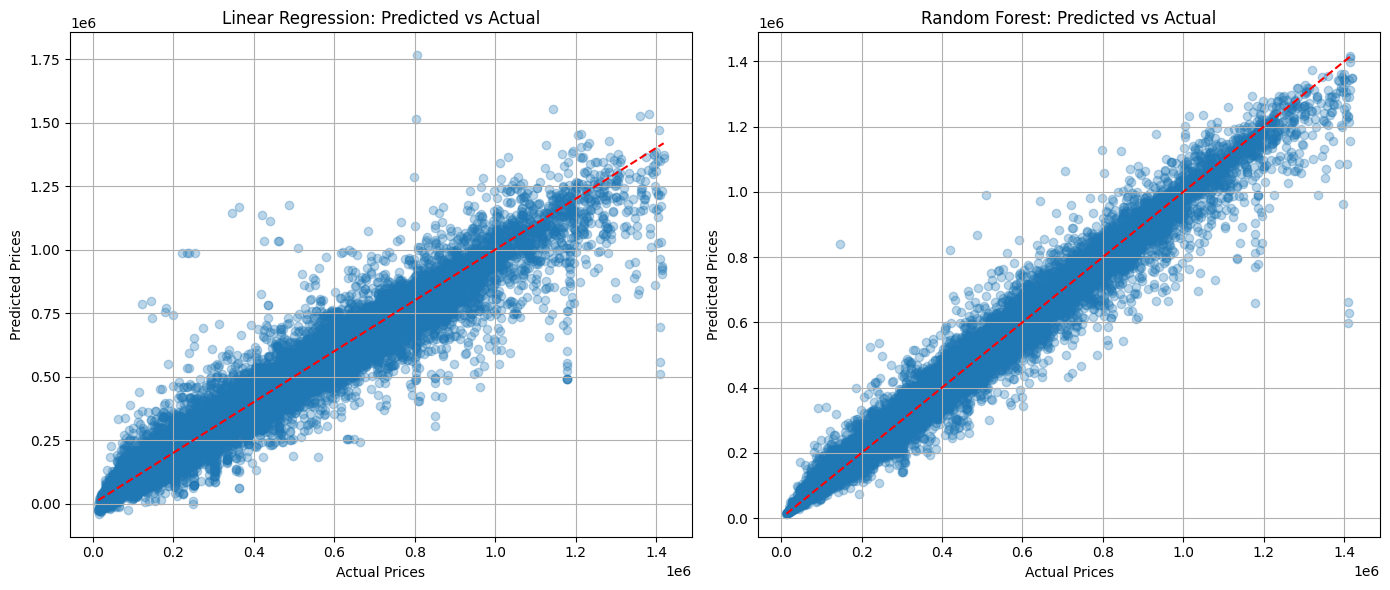

In [40]:
#Plot predicted vs actual housing prices Linear Regression and Random Forest
import matplotlib.pyplot as plt

# Make predictions without retraining
y_pred_lr = pipelines["Linear Regression"].predict(X_test)
y_pred_rf = pipelines["Random Forest"].predict(X_test)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression plot
axes[0].scatter(y_test, y_pred_lr, alpha=0.3)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
axes[0].set_title("Linear Regression: Predicted vs Actual")
axes[0].set_xlabel("Actual Prices")
axes[0].set_ylabel("Predicted Prices")
axes[0].grid(True)

# Random Forest plot
axes[1].scatter(y_test, y_pred_rf, alpha=0.3)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
axes[1].set_title("Random Forest: Predicted vs Actual")
axes[1].set_xlabel("Actual Prices")
axes[1].set_ylabel("Predicted Prices")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [53]:
#Get top 10 features for each model

import pandas as pd
import numpy as np

# ----- Random Forest -----
rf_model = pipelines["Random Forest"].named_steps['model']
rf_preprocessor = pipelines["Random Forest"].named_steps['preprocessor']

# Get feature names after preprocessing
cat_features = rf_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
num_features = numeric_cols
all_features = np.concatenate([cat_features, num_features])

# RF feature importances
rf_importances = pd.Series(rf_model.feature_importances_, index=all_features)
rf_top10 = rf_importances.sort_values(ascending=False).head(10)
print("Top 10 Random Forest Features:\n", rf_top10)

# ----- Linear Regression -----
lr_model = pipelines["Linear Regression"].named_steps['model']
lr_preprocessor = pipelines["Linear Regression"].named_steps['preprocessor']

# Get coefficients
lr_coeffs = pd.Series(lr_model.coef_, index=all_features)
lr_coeffs_abs = lr_coeffs.abs()
lr_top10 = lr_coeffs_abs.sort_values(ascending=False).head(10)
print("\nTop 10 Linear Regression Features (by absolute coefficient):\n", lr_top10)


Top 10 Random Forest Features:
 median_sale_price      0.737818
median_list_price      0.195539
Median Home Value      0.022670
year                   0.003692
median_list_ppsf       0.002919
median_ppsf            0.002750
Median Rent            0.001857
Per Capita Income      0.001666
Total Housing Units    0.001542
Median Age             0.001393
dtype: float64

Top 10 Linear Regression Features (by absolute coefficient):
 Median Age                               2410.195635
bank                                      599.511149
hospital                                  291.053322
year                                      249.201939
median_ppsf                               168.039102
homes_sold                                161.330548
median_list_ppsf                          137.727697
restaurant                                132.056405
new_listings                              109.742761
city_full_New York-Newark-Jersey City     101.594110
dtype: float64


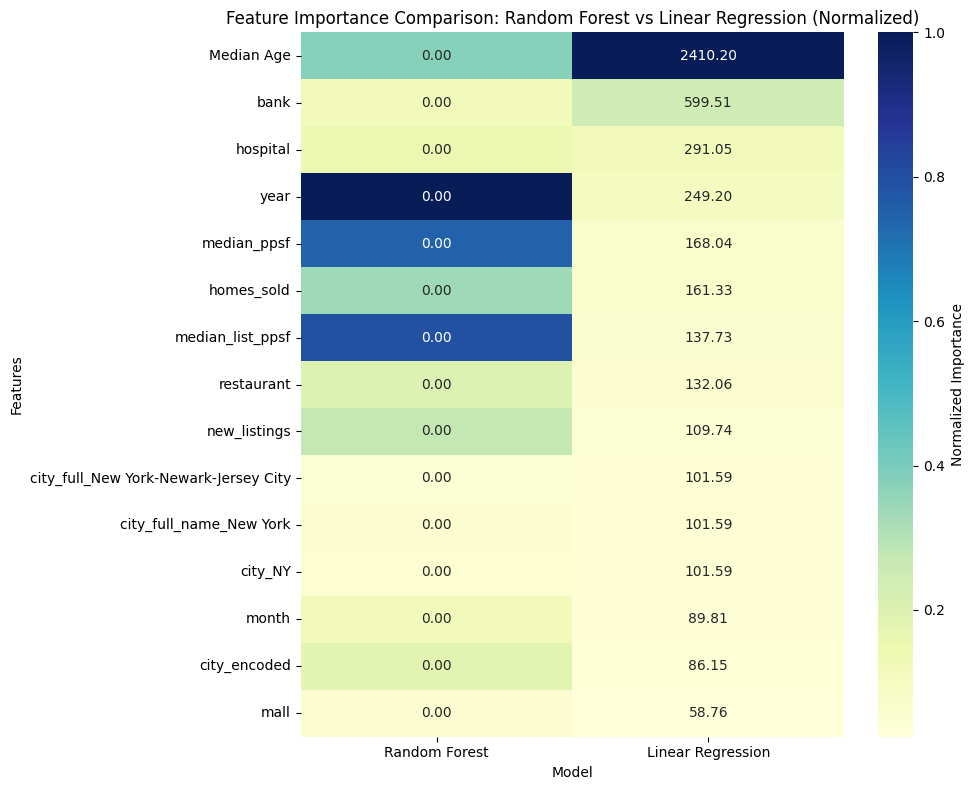

In [56]:
#Create heatmap to reflect relative importnace within each model to see which features each model favors


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# ----- Extract feature names -----
rf_model = pipelines["Random Forest"].named_steps['model']
rf_preprocessor = pipelines["Random Forest"].named_steps['preprocessor']
cat_features = rf_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([cat_features, numeric_cols])

# ----- Feature importances -----
rf_importances = pd.Series(rf_model.feature_importances_, index=all_features)
lr_model = pipelines["Linear Regression"].named_steps['model']
lr_coeffs = pd.Series(lr_model.coef_, index=all_features).abs()  # use absolute value

# ----- Combine into DataFrame -----
feat_df = pd.DataFrame({
    "Random Forest": rf_importances,
    "Linear Regression": lr_coeffs
})

# ----- Select top 15 features by either model -----
top_features = feat_df.max(axis=1).sort_values(ascending=False).head(15).index
feat_df_top = feat_df.loc[top_features]

# ----- Normalize each column independently -----
feat_df_norm = feat_df_top / feat_df_top.max()

# ----- Plot heatmap -----
plt.figure(figsize=(10, 8))
sns.heatmap(feat_df_norm, annot=feat_df_top, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Normalized Importance'})
plt.title("Feature Importance Comparison: Random Forest vs Linear Regression (Normalized)")
plt.ylabel("Features")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


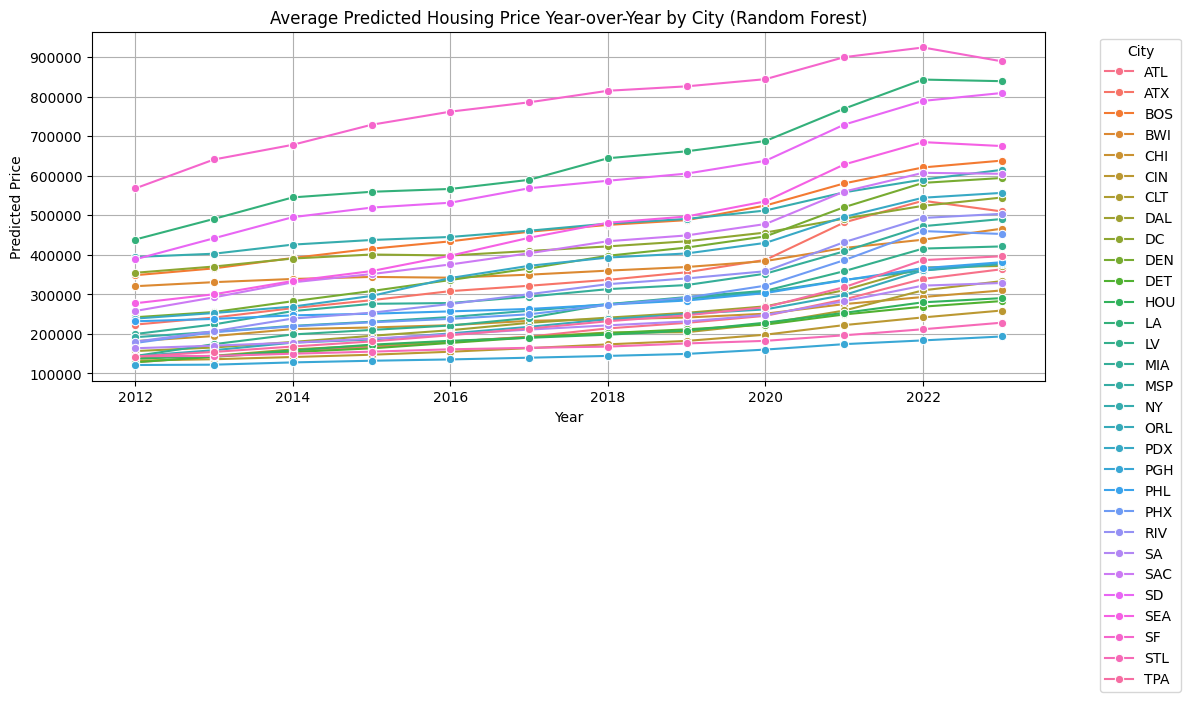

In [58]:
#Random Forest model by city and year
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume you have the full dataset df with 'city' and 'year' columns
# Make predictions with the trained Random Forest pipeline
df_sample = df.copy()  # or use a smaller sample if needed
X_all = df_sample.drop('price', axis=1)
df_sample['predicted_price'] = pipelines["Random Forest"].predict(X_all)

# Aggregate by city and year
avg_price = df_sample.groupby(['city', 'year'], observed=True)['predicted_price'].mean().reset_index()

# Plot year-over-year trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price, x='year', y='predicted_price', hue='city', marker='o')
plt.title("Average Predicted Housing Price Year-over-Year by City (Random Forest)")
plt.ylabel("Predicted Price")
plt.xlabel("Year")
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



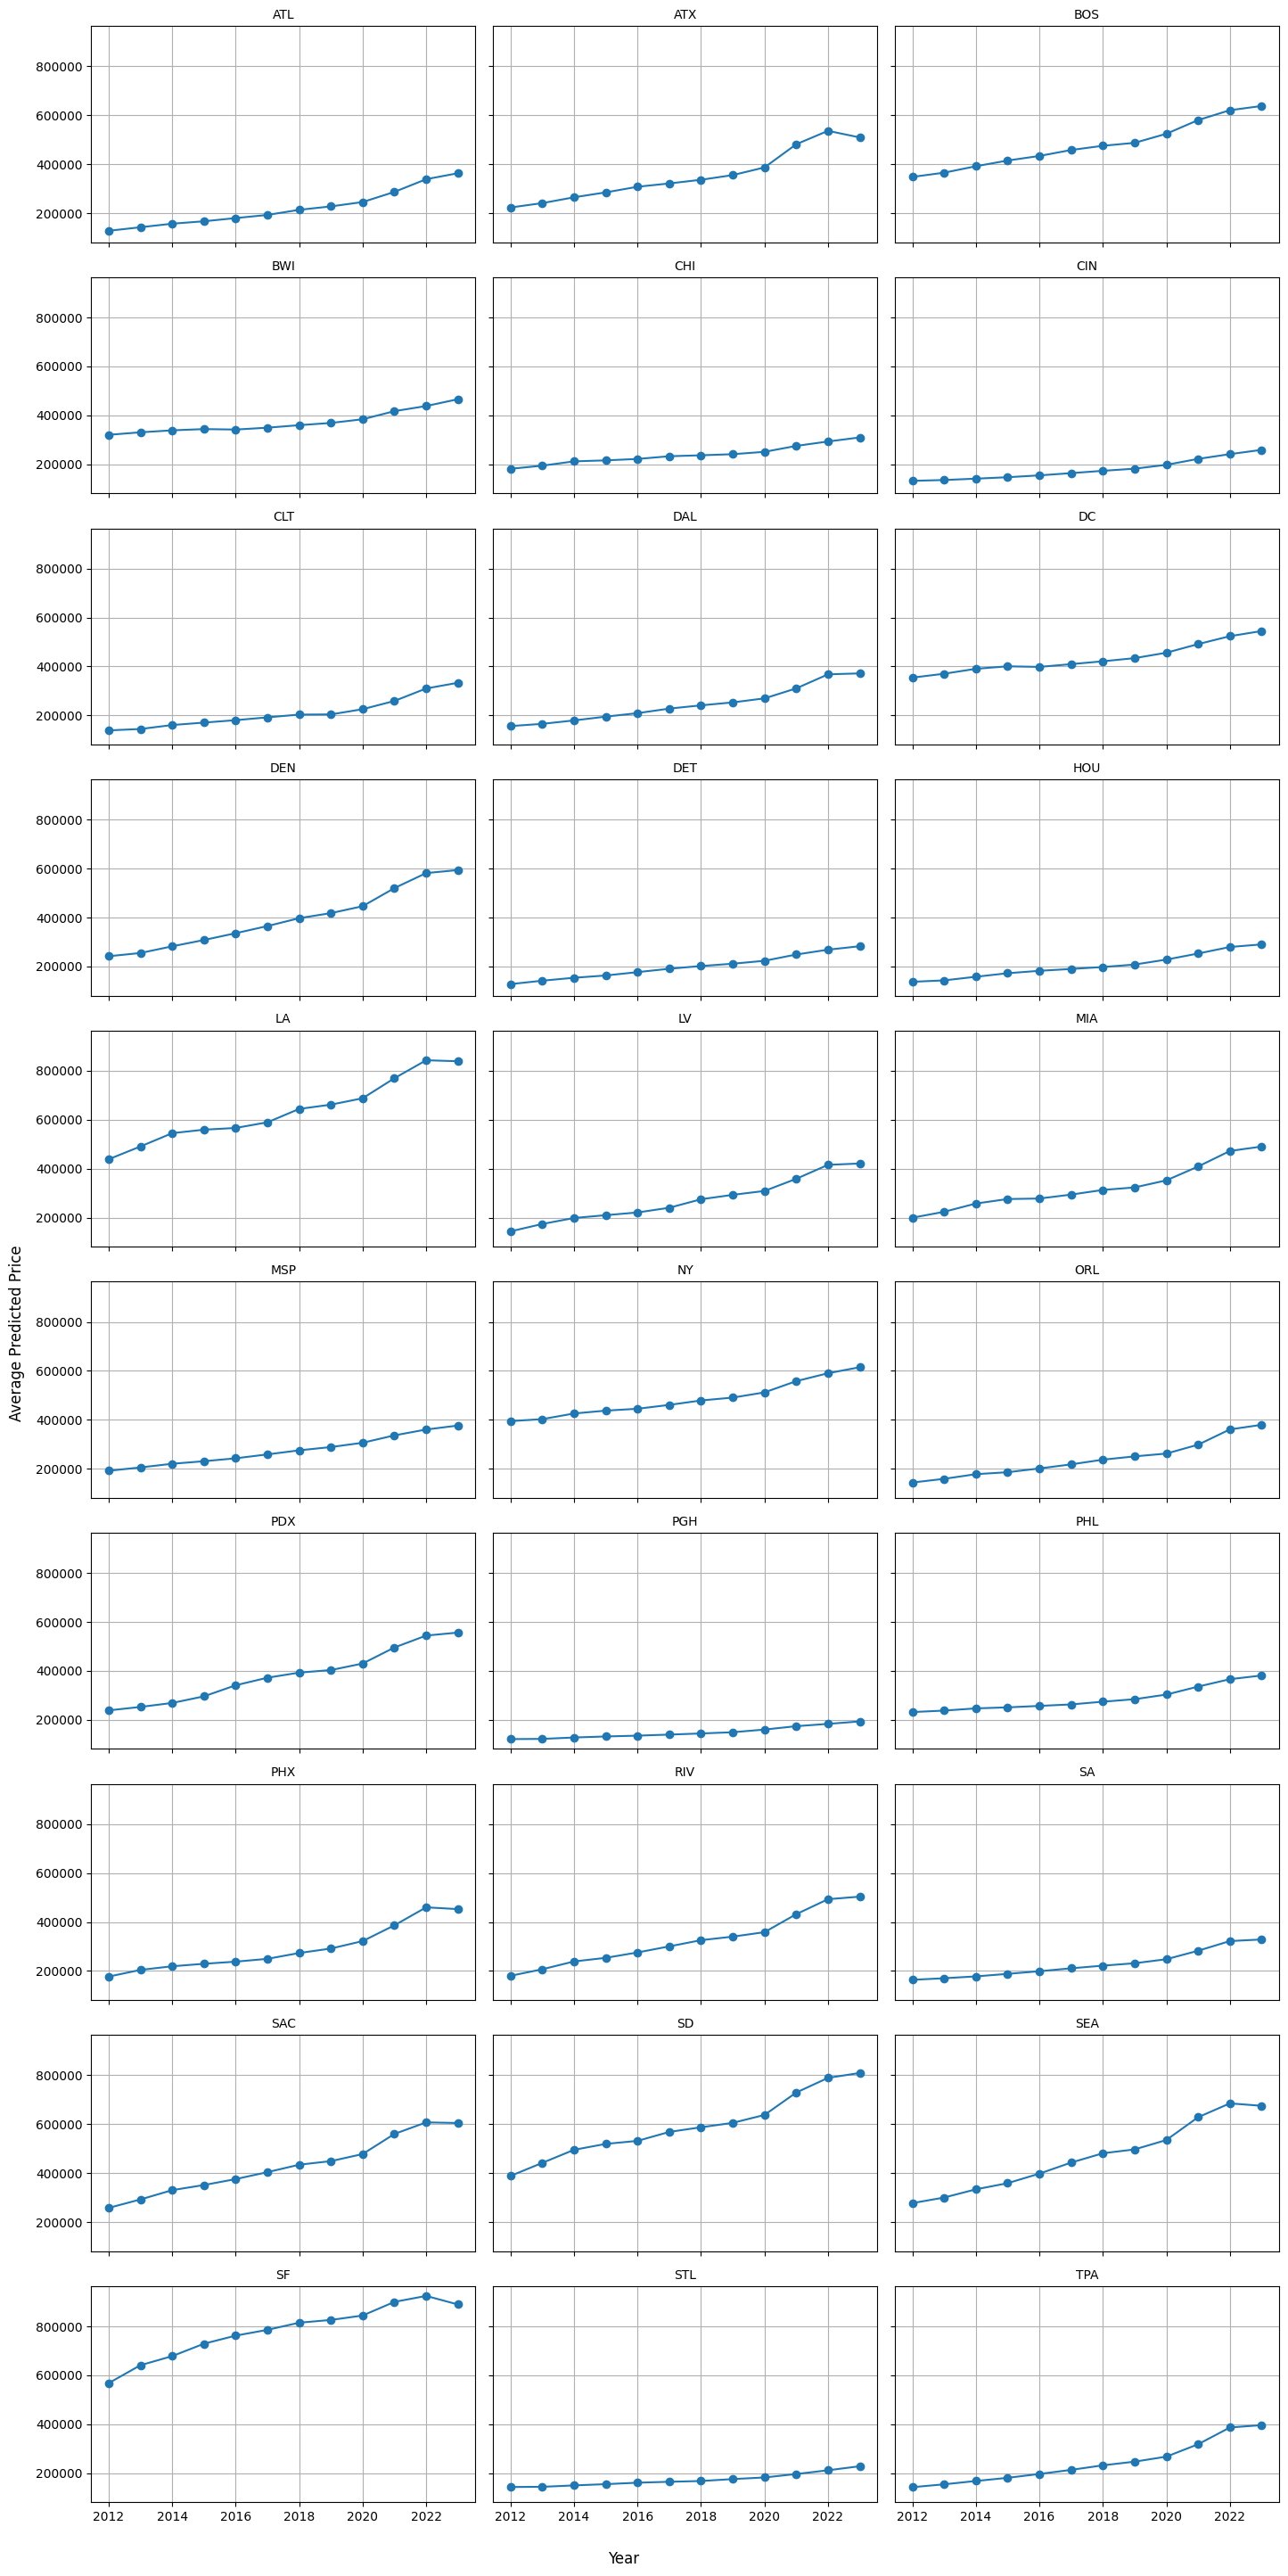

In [61]:
# One plot per city

import matplotlib.pyplot as plt
import math

# Group by city and year, calculate average predicted price
avg_price = df_sample.groupby(['city', 'year'], observed=True)['predicted_price'].mean().reset_index()
cities = avg_price['city'].unique()

# Grid layout: adjust columns (e.g., 3 per row)
n_cols = 3
n_rows = math.ceil(len(cities) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten for easy iteration

for i, city in enumerate(cities):
    city_data = avg_price[avg_price['city'] == city]
    axes[i].plot(city_data['year'], city_data['predicted_price'], marker='o')
    axes[i].set_title(city, fontsize=10)
    axes[i].grid(True)

# Turn off any extra axes if number of cities < n_rows*n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.text(0.5, 0.04, 'Year', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Average Predicted Price', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()



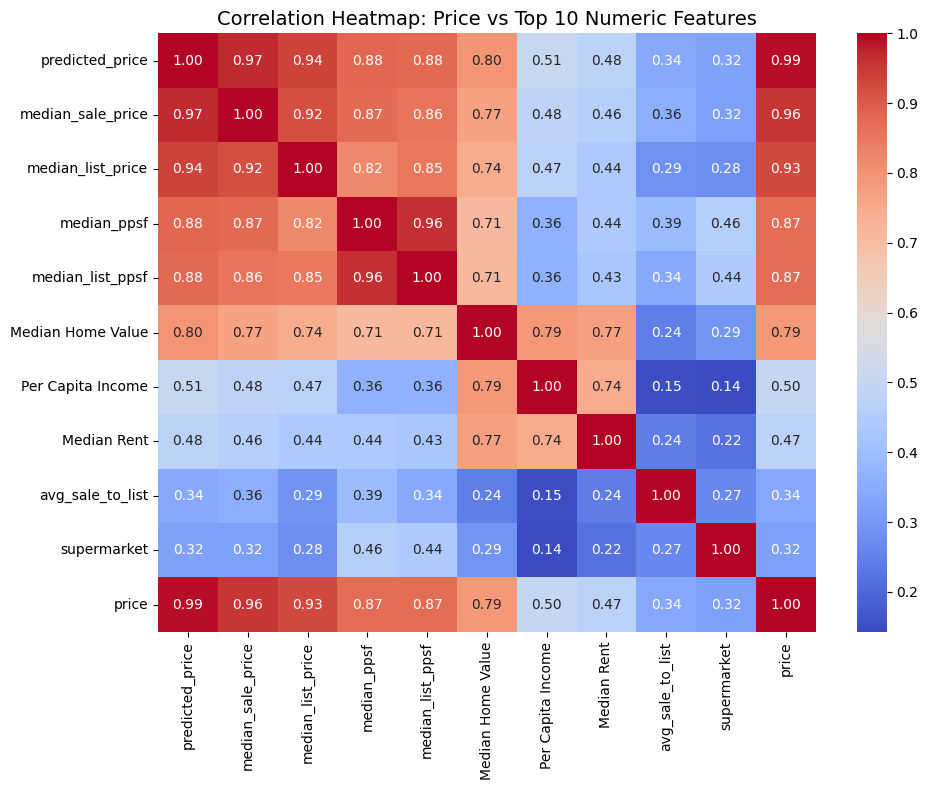

In [63]:
#Generate heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only numeric columns
numeric_df = df_sample.select_dtypes(include=['number'])

# Compute correlations with target
corr_matrix = numeric_df.corr()
target_corr = corr_matrix['price'].abs().sort_values(ascending=False)

# Select top 10 correlated features (excluding price itself)
top_features = target_corr.drop('price').head(10).index.tolist()

# Subset correlation matrix for heatmap
top_corr = numeric_df[top_features + ['price']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap: Price vs Top 10 Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()

